# Introduction

For statistical analysis we think of data as a collection of different pieces of information or facts. These pieces of information are called variables. A variable is an identifiable piece of data containing one or more values. Those values can take the form of a number or text (which could be converted into number)

This dataset contains $80,332$ reports of UFO sightings during the last century. Each report or observation consists of 11 variables. These are datetime, city, state, country, shape, duration (seconds), duration (hours / min), comments, date posted, latitude, longitude of each sighting. Each of these variables contains specific information about the sightings. As shown in the table below

$ $

$$\begin{array}{ccc}
\boldsymbol{variable} & \mathbf{description} & \mathbf{Format}\\
datetime & date\:and\:time\:of\:event & String\\
city & Name\:of\:the\:city & String\\
state & State\:code\:of\:even & String\\
country & Country\:code\:of\:event & String\\
shape & Shape\:of\:the\:UFO & String\\
duration(seconds) & Durantion\:of\:the\:sighting\:in\:seconds & Numeric\\
duration(hours/min) & Durantion\:of\:the\:sighting\:in\:hours\:and\:minutes & String\\
comments & Description\:of\:the\:event & String\\
date\:posted & Date\:when\:the\:event\:was\:reported & Date\\
latitude & Latitude\:of\:the\:city & Numeric\\
longitude & Longitude\:of\:the\:city & Numeric
\end{array}$$

The intention is to provide information for people who want to precede a UFO event about the locations, most likely dates and what they can expect to see.

In [ ]:
### First we are going to import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from collections import Counter, OrderedDict
import seaborn as sns
import re
from sklearn.cluster import KMeans

In [ ]:
### Now we are going to access the Google Drive public folder that contains the data.

url='https://drive.google.com/file/d/18ebUBx5nSTzurfjdl8EINEURrPkFQbXU/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
ufo = pd.read_csv(dwn_url, encoding='latin1')

length_of_set = len(ufo['datetime'])
print(length_of_set)
ufo.head()

80332


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


# Profiling of data completeness and quality

## Exploring and cleaning UFO Sightings

First let's explore the data and do some descriptive analysis and cleaning.


Shapes to consider
['cylinder' 'light' 'circle' 'sphere' 'disk' 'fireball' 'unknown' 'oval'
 'other' 'cigar' 'rectangle' 'chevron' 'triangle' 'formation' nan 'delta'
 'changing' 'egg' 'diamond' 'flash' 'teardrop' 'cone' 'cross' 'pyramid'
 'round' 'crescent' 'flare' 'hexagon' 'dome' 'changed']


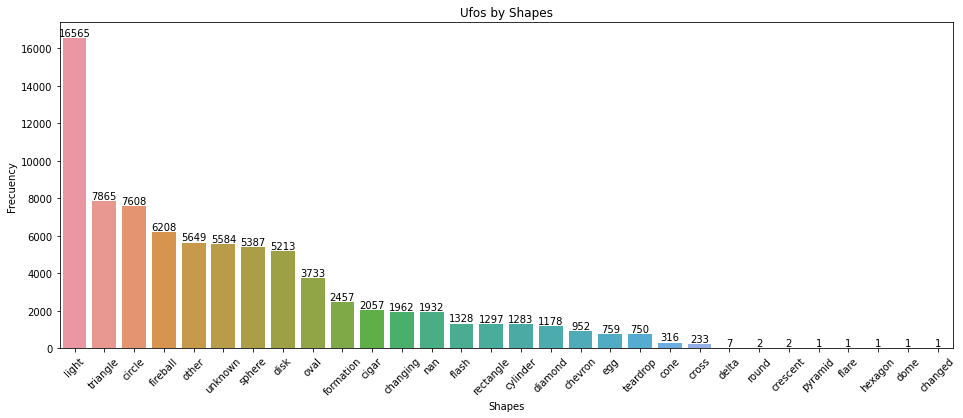

In [ ]:
## Ufos by Shape

def get_shape_bar_plot(ufo):
  shape_set = ufo['shape']
  print('Shapes to consider')
  print(shape_set.unique())

  shape_counter = Counter(shape_set)

  col1 = []
  col2 = []
  for shape, count in shape_counter.most_common(len(shape_set.unique())):
    col1.append(str(shape))
    col2.append(count)

  d = {'Shapes': col1, 'Frecuency': col2}
  d = pd.DataFrame(d, columns=['Shapes', 'Frecuency'])

  plt.figure(figsize=(16, 6))
  plots = sns.barplot(x='Shapes', y='Frecuency', data = d)

  for bar in plots.patches:
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
  plt.xticks(rotation=45)
  plt.title('Ufos by Shapes')
  plt.show()

get_shape_bar_plot(ufo)

The most usual UFO shape, as shown in the graph above, is 'light' and the number 4 is 'fireball', strictly they are Uknown Flying Objects, but if we are looking for aliens, a simple light or fireball is not a serious shape to deduct the existence of aliens. 

If we consider the possibility that these forms are related to optical effects, or astronomical or atmospheric events, we could group these data under a new label 'natural events' and after discarding these data, the cases where more specific forms were observed could be further analyzed.



Shapes to consider
['cylinder' 'natural event' 'circle' 'sphere' 'disk' 'unknown' 'oval'
 'other' 'cigar' 'rectangle' 'chevron' 'triangle' 'formation' 'nan'
 'delta' 'egg' 'diamond' 'teardrop' 'cone' 'cross' 'pyramid' 'round'
 'hexagon' 'dome']


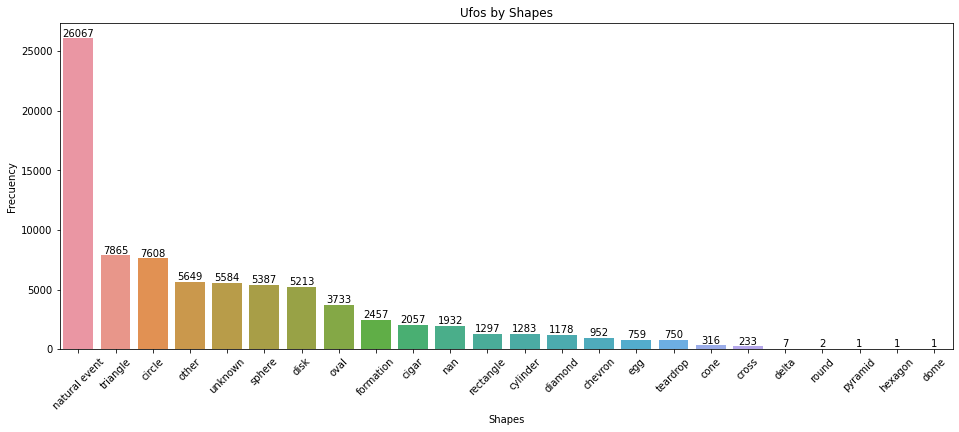

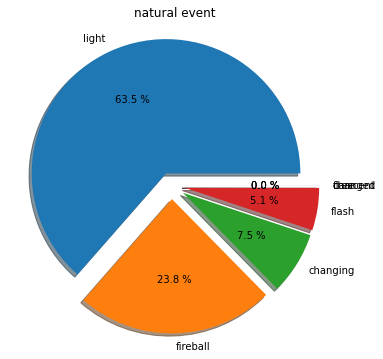

In [ ]:
join_labels = ['light', 'fireball', 'changing', 'flash', 'crescent', 'flare', 'changed']


def join_labels_fun(join_labels, new_label, ufo):
  shape_labels = ufo['shape']
  new_shape_labels = []
  for shape in shape_labels:
    bool_list = []
    for i in range(len(join_labels)):
      bool_list.append(str(shape) == join_labels[i])
    if np.any(bool_list):
      new_shape_labels.append(new_label)
    else:
      new_shape_labels.append(str(shape))
  return new_shape_labels

def get_pai(new_label, ufo, copy_ufo):
  shape_set = ufo[copy_ufo['shape']== new_label]
  shape_counter = Counter(shape_set['shape'])
  col1 = []
  col2 = []
  for shape, count in shape_counter.most_common(len(shape_set['shape'].unique())):
    col1.append(str(shape))
    col2.append(count)
  plt.figure(figsize=(6, 6))
  explode = np.ones(len(col1))*0.1
  plt.pie(col2, labels=col1, autopct="%1.1f %%", explode=explode,  shadow=True)
  plt.title(new_label)
  plt.axis("equal")
  plt.show()


new_shape_labels = join_labels_fun(join_labels, 'natural event', ufo)

copy_ufo = ufo.copy()
copy_ufo['shape'] = new_shape_labels
get_shape_bar_plot(copy_ufo)
get_pai('natural event', ufo, copy_ufo)


Now that possible natural events have been ruled out, we will study a little the possible forms of ships.

According to http://www.aliens-everything-you-want-to-know.com/AlienSpacecraft.html we have the following types of ships:

**Saucer or Disk-shaped Craft**

These come in different configurations and sizes. Some have small domes or cupolas on top, and some do not. The dome configuration can be rounded or square. These are known to be primarily scout ships and short-range research vehicles.

**Cigar-shaped Craft**

These vehicles are generally larger than saucers. They are known to be small mother ships containing eight to ten saucer-shaped craft. They are long and cylindrical with a taper at both ends; thus the name.

**Triangle-shaped Craft**

These ships are huge; many stretch over several miles along a single edge. These are the craft that were sighted over Belgium in the wave of sightings taking place there in 1989-1990. It is estimated that over 70 percent of the entire population of Belgium saw these craft firsthand, and as a result, Belgium is the only country that officially recognizes the existence of flying saucers.

**Boomerang**

These craft are also gigantic. They differ somewhat from the triangle-shaped craft in that one arm of the boomerang ship is longer than the other. These are the sort of craft that have been seen and videotaped by thousands of citizens in Phoenix, Arizona in March and April 1997.


Following these descriptions we can add more kinds of sightings according to their shape

In [ ]:
ufo = copy_ufo 

Shapes to consider
['cylinder' 'natural event' 'saucer-shaped craft' 'unknown' 'other'
 'cigar' 'rectangle' 'chevron' 'triangle' 'formation' 'nan' 'delta'
 'diamond' 'teardrop' 'cone' 'cross' 'pyramid']


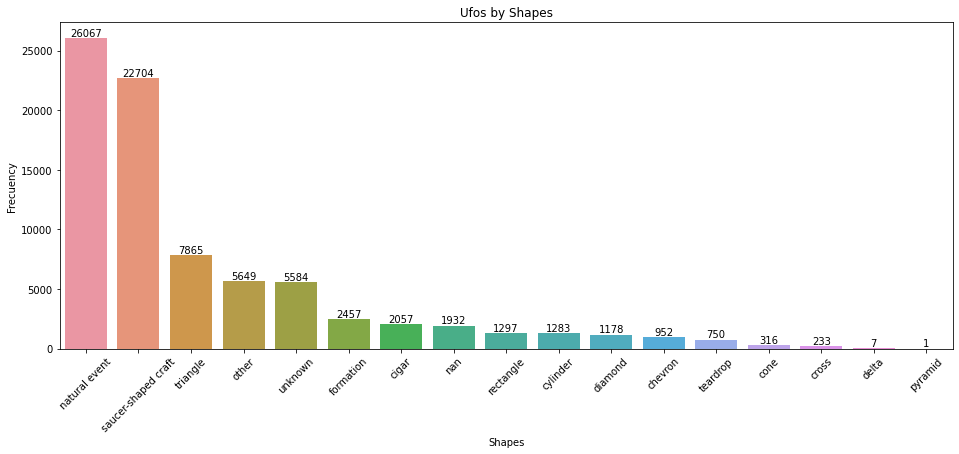

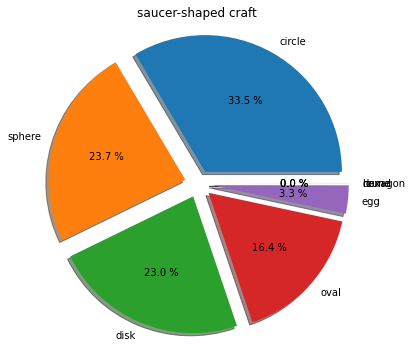

In [ ]:
join_labels = ['circle', 'sphere', 'disk', 'oval', 'egg',  'round', 'hexagon', 'dome']

new_shape_labels = join_labels_fun(join_labels, 'saucer-shaped craft', ufo)
copy_ufo = ufo.copy()
copy_ufo['shape'] = new_shape_labels
get_shape_bar_plot(copy_ufo)
get_pai('saucer-shaped craft', ufo, copy_ufo)

In [ ]:
ufo = copy_ufo 

Shapes to consider
['cigar-shaped craft' 'natural event' 'saucer-shaped craft' 'unknown'
 'other' 'chevron' 'triangle' 'formation' 'nan' 'delta' 'cross' 'pyramid']


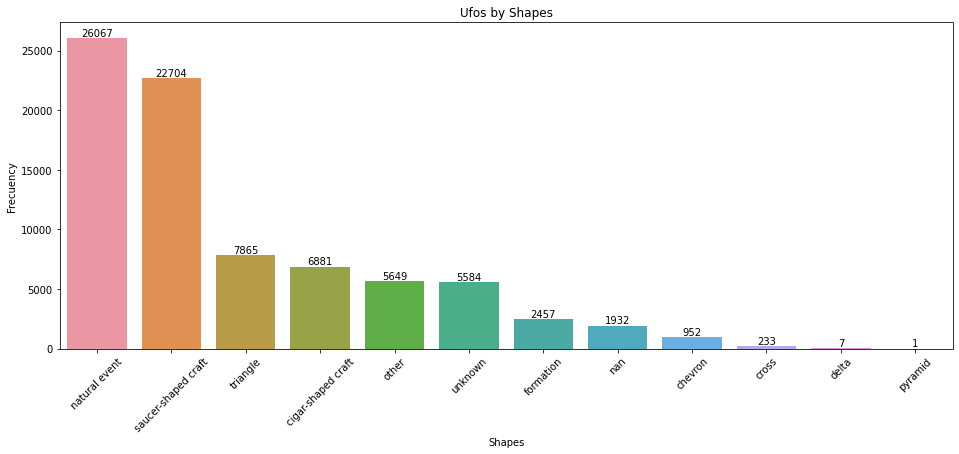

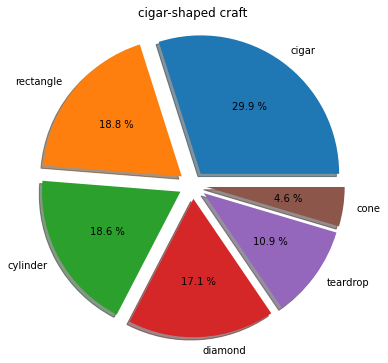

In [ ]:
join_labels = ['cylinder', 'cigar', 'rectangle', 'diamond', 'teardrop', 'cone']

new_shape_labels = join_labels_fun(join_labels, 'cigar-shaped craft', ufo)
copy_ufo = ufo.copy()
copy_ufo['shape'] = new_shape_labels
get_shape_bar_plot(copy_ufo)
get_pai('cigar-shaped craft', ufo, copy_ufo)

In [ ]:
ufo = copy_ufo 

Shapes to consider
['cigar-shaped craft' 'natural event' 'saucer-shaped craft' 'unknown'
 'other' 'chevron' 'triangle-shaped craft' 'formation' 'nan' 'cross']


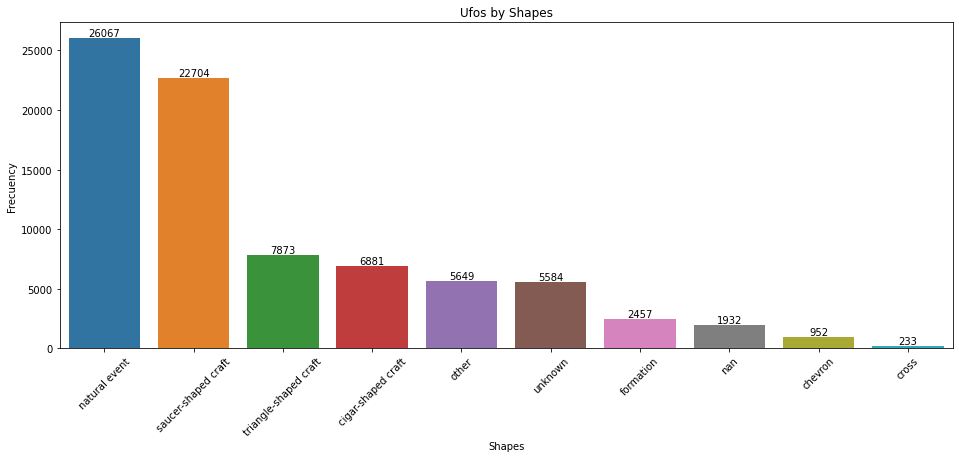

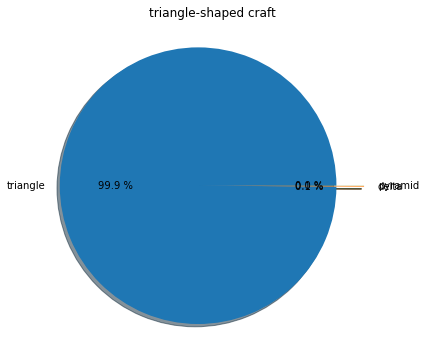

In [ ]:
join_labels = ['triangle', 'pyramid', 'delta']

new_shape_labels = join_labels_fun(join_labels, 'triangle-shaped craft', ufo)
copy_ufo = ufo.copy()
copy_ufo['shape'] = new_shape_labels
get_shape_bar_plot(copy_ufo)
get_pai('triangle-shaped craft', ufo, copy_ufo)

In [ ]:
ufo = copy_ufo 

Shapes to consider
['cigar-shaped craft' 'natural event' 'saucer-shaped craft' 'unknown'
 'other' 'boomerang' 'triangle-shaped craft' 'nan']


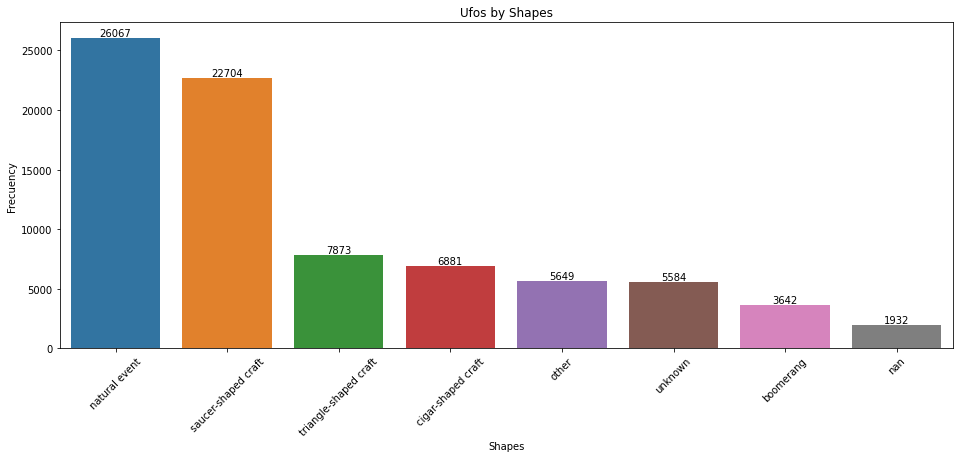

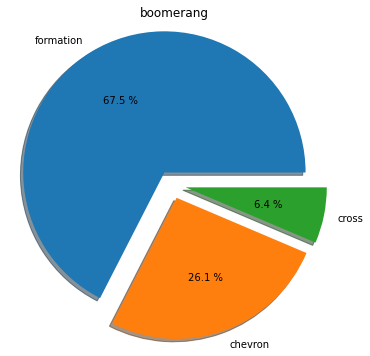

In [ ]:
join_labels = ['chevron', 'formation','cross', 'delata']

new_shape_labels = join_labels_fun(join_labels, 'boomerang', ufo)
copy_ufo = ufo.copy()
copy_ufo['shape'] = new_shape_labels
get_shape_bar_plot(copy_ufo)
get_pai('boomerang', ufo, copy_ufo)

**Note** The forms 'formation' and 'cross' are grouped under the class boomeran since it is possible to suppose that seen from below, the distribution of the lights of this type of ships can be confused with these forms

In [ ]:
ufo = copy_ufo 

Shapes to consider
['cigar-shaped craft' 'natural event' 'saucer-shaped craft' 'other'
 'boomerang' 'triangle-shaped craft']


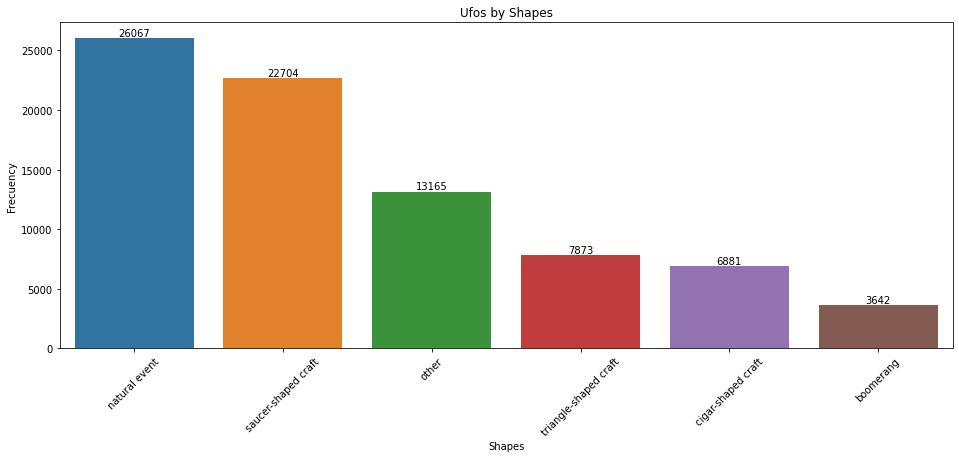

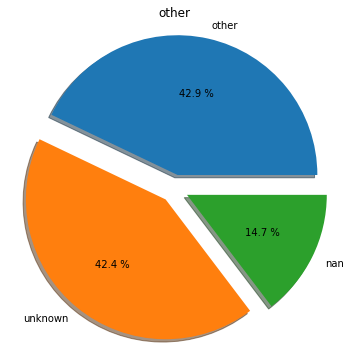

In [ ]:
join_labels = ['unknown', 'other', 'nan']

new_shape_labels = join_labels_fun(join_labels, 'other', ufo)
copy_ufo = ufo.copy()
copy_ufo['shape'] = new_shape_labels
get_shape_bar_plot(copy_ufo)
get_pai('other', ufo, copy_ufo)

In order to focus on alien-related sightings we will discard the data that we have labeled as natural events.

Shapes to consider
['cigar-shaped craft' 'saucer-shaped craft' 'other' 'boomerang'
 'triangle-shaped craft']


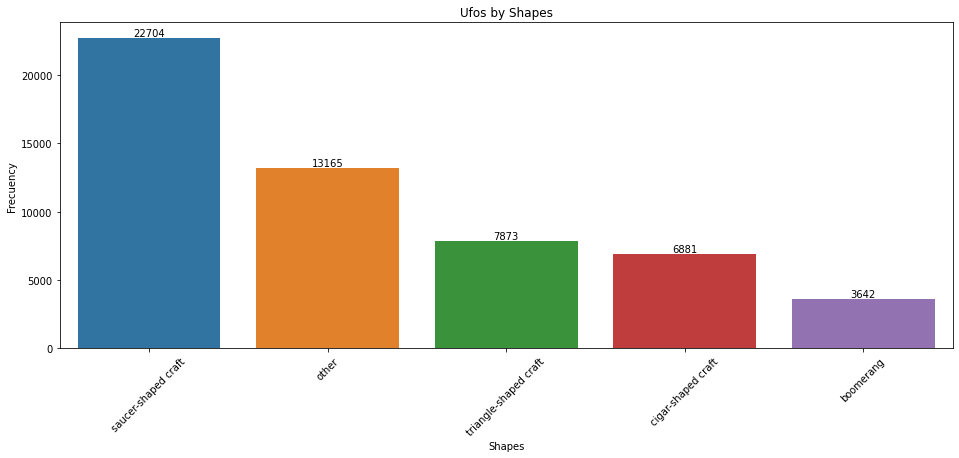

In [ ]:
ufo = copy_ufo

subset = ufo[ufo['shape']!='natural event']
get_shape_bar_plot(subset)

In [ ]:
length_of_set = len(ufo['datetime'])
length_of_subset = len(subset['datetime'])
print(length_of_subset)
print('Percent of data remaining: {:.2f}%'.format((length_of_subset/length_of_set)*100))

54265
Percent of data remaining: 67.55%


We have kept $67.55\%$ of the original data. Now we are going to focus on the variable 'duration (seconds)'

In [ ]:
ufo = subset

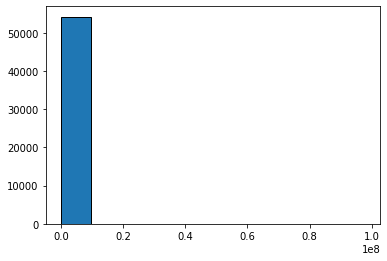

In [ ]:
## Ufos by duration (seconds)

duration_set = ufo['duration (seconds)']
durations = []
for duration in duration_set:
  try: 
    val = float(duration)
  except:
    #print(duration)
    duration = re.sub('`', "", str(duration))
    #print(duration)

  durations.append(str(duration)) 

copy_ufo = ufo.copy()
copy_ufo['duration (seconds)'] = np.array(durations, float)

plt.hist(copy_ufo['duration (seconds)'],  edgecolor='black')
plt.show()

We can make a widely accepted assumption that sightings do not last for a very long time. As can be seen in the histogram, there are events with a very long duration, although they are not the majority.

In a quick search we can realize that these sightings last a few minutes. It is very rare that they arrive at  1 hours. To give a margin to error we will assume a maximum time of 2 hours and the data that have a longer duration will be discarded

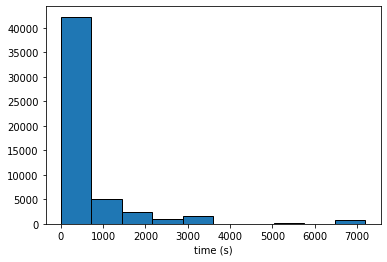

In [ ]:
subset = copy_ufo[copy_ufo['duration (seconds)']<=2*60*60]

plt.hist(subset['duration (seconds)'],  edgecolor='black' )
plt.xlabel('time (s)')
plt.show()

In [ ]:
length_of_set = len(ufo['datetime'])
length_of_subset = len(subset['datetime'])
print('Percentage of the data remaining after having removed as mentioned before: {:.2f}%'.format(( length_of_subset/length_of_set)*100))

Percentage of the data remaining after having removed as mentioned before: 98.10%


In [ ]:
ufo = subset

Now we are going to focus on the variable 'country'

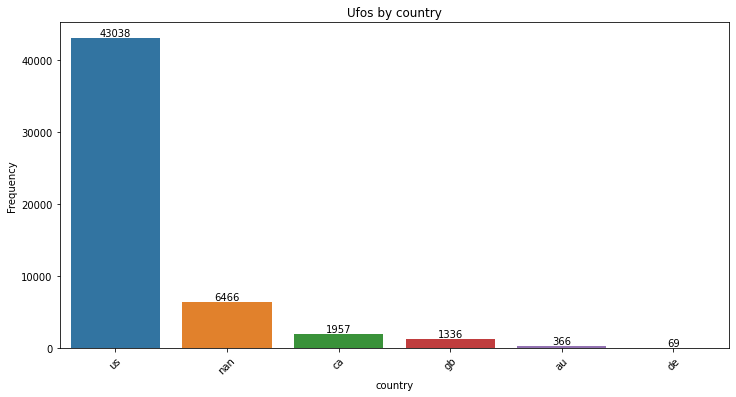

In [ ]:
## UFOs Ciyt/Country/State

def get_country_bar_plot(ufo, var): 
  country_set = ufo[var] 
  country_counter = Counter(country_set)
  col1 = []
  col2 = []
  for country, count in country_counter.most_common(len(country_set.unique())):
    col1.append(str(country))
    col2.append(count)
  d = {var: col1, 'Frequency': col2}
  d = pd.DataFrame(d, columns=[var, 'Frequency'])
  plt.figure(figsize=(12, 6))
  plots = sns.barplot(x=var, y='Frequency', data = d)
  for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
  
  plt.title('Ufos by '+ var )
  plt.xticks(rotation=45)
  plt.show()


get_country_bar_plot(ufo, 'country' )

In [ ]:
subset = ufo[np.array(ufo['country'], str) != 'nan']
length_of_set = len(ufo['datetime'])
length_of_subset = len(subset['datetime'])
print('Percentage of the data with incomplete reports in the variables country: {:.2f}%'.format((1 - length_of_subset/length_of_set)*100))

Percentage of the data with incomplete reports in the variables country: 12.15%


$12.15\%$ of the data have null entries in the variable country

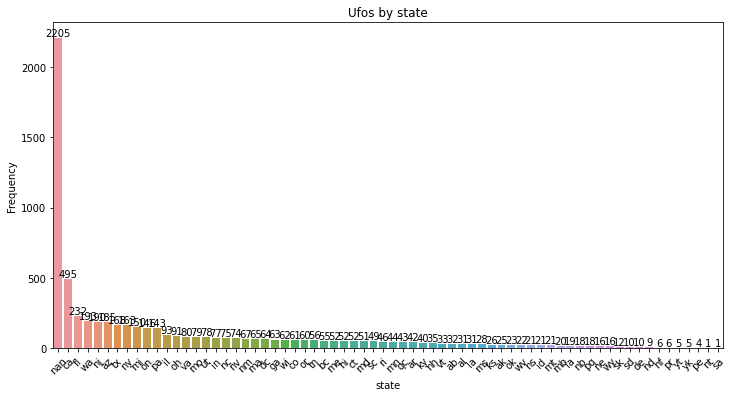

In [ ]:
subset = ufo[np.array(ufo['country'], str) == 'nan']
get_country_bar_plot(subset, 'state' )

In [ ]:
sub_subset = subset[np.array(subset['state'], str) == 'nan']
#length_of_subset = len(subset['datetime'])
length_of_sub_subset = len(sub_subset['datetime'])
print('Percentage of the data with incomplete reports in the variables country and state: {:.2f}%'.format((length_of_sub_subset/length_of_set)*100))
print('Number of data with incomplete reports in country and state and city: {}'.format(len(sub_subset[np.array(sub_subset['city'], str)=='nan']['datetime'])))

Percentage of the data with incomplete reports in the variables country and state: 4.14%
Number of data with incomplete reports in country and state and city: 0


As we can see the data includes entries where the location (state and country) of the sighting was not report or blank ($4.14\%$). Let's take a look at those data entries, especially the city variable in order to see if it is possible to complete it.

In [ ]:
sub_subset.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
35,10/10/1982 07:00,gisborne (new zealand),NaN,NaN,saucer-shaped craft,120.0,2min,gisborne nz 1982 wainui beach to sponge bay,1/11/2002,-38.662334,178.017649
55,10/10/1993 03:00,zlatoust (russia),NaN,NaN,saucer-shaped craft,1200.0,20 minutes,I woke up at night and looked out the window n...,12/14/2004,55.183333,59.650000
125,10/10/2003 23:00,bickerton (near wetherby) (uk/england),NaN,NaN,other,2700.0,45minutes,two bright&#44 but fuzzy lights going in a hov...,10/15/2003,53.070884,-2.736506
136,10/10/2004 15:20,kedainiai (lithuania),NaN,NaN,saucer-shaped craft,240.0,4min,6 oval light objects very quickly rounded unde...,10/27/2004,55.288131,23.957728
296,10/11/1997 22:00,hafnarfjordur (iceland),NaN,NaN,saucer-shaped craft,300.0,5 min,playing with a jet,6/12/2008,64.066667,-21.950000


In [ ]:
sub_subset['city']

35                                  gisborne (new zealand)
55                                       zlatoust (russia)
125                 bickerton (near wetherby) (uk/england)
136                                  kedainiai (lithuania)
296                                hafnarfjordur (iceland)
                               ...                        
79961                                       bryne (norway)
79968                     yatton&#44 somerset (uk/england)
80089                                    limassol (cyprus)
80131    cozumel (mexico) and ocho rios (jamaica) (betw...
80190                                          dubai (uae)
Name: city, Length: 2205, dtype: object

As we can see, it may be possible to assign a country to some of these data since the information appears in the variable city.

In [ ]:
# Country Clean Column 
data_column = np.array(sub_subset['city'], str)
expression = re.compile("\((.*?)\)")

data_cleaned = []

for val in data_column:
  results = expression.findall(val)
  try:
    data_cleaned.append(results[-1])
  except:
    data_cleaned.append(val)

sub_subset['country'] = data_cleaned

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sub_subset.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
35,10/10/1982 07:00,gisborne (new zealand),NaN,new zealand,saucer-shaped craft,120.0,2min,gisborne nz 1982 wainui beach to sponge bay,1/11/2002,-38.662334,178.017649
55,10/10/1993 03:00,zlatoust (russia),NaN,russia,saucer-shaped craft,1200.0,20 minutes,I woke up at night and looked out the window n...,12/14/2004,55.183333,59.650000
125,10/10/2003 23:00,bickerton (near wetherby) (uk/england),NaN,uk/england,other,2700.0,45minutes,two bright&#44 but fuzzy lights going in a hov...,10/15/2003,53.070884,-2.736506
136,10/10/2004 15:20,kedainiai (lithuania),NaN,lithuania,saucer-shaped craft,240.0,4min,6 oval light objects very quickly rounded unde...,10/27/2004,55.288131,23.957728
296,10/11/1997 22:00,hafnarfjordur (iceland),NaN,iceland,saucer-shaped craft,300.0,5 min,playing with a jet,6/12/2008,64.066667,-21.950000


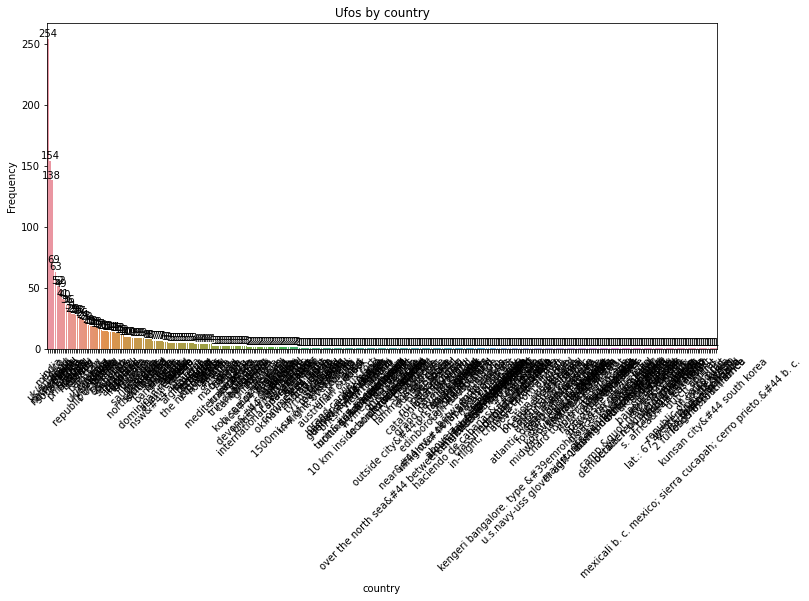

In [ ]:
get_country_bar_plot(sub_subset, 'country')

As we can see from this horrible graph, it is not feasible to try to complete this data. For this reason they will be removed

In [ ]:
positions = []
nan_countries = np.array(ufo['country'], str) == 'nan'
nan_states = np.array(ufo['state'], str) == 'nan'

for i in range(len(ufo['datetime'])):
  positions.append(not nan_countries[i] or not nan_states[i])

ufo = ufo[positions]

In [ ]:
ufo.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cigar-shaped craft,2700.0,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
2,10/10/1955 17:00,chester (uk/england),NaN,gb,saucer-shaped craft,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,saucer-shaped craft,20.0,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
5,10/10/1961 19:00,bristol,tn,us,saucer-shaped craft,300.0,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.5950000,-82.188889
6,10/10/1965 21:00,penarth (uk/wales),NaN,gb,saucer-shaped craft,180.0,about 3 mins,penarth uk circle 3mins stayed 30ft above m...,2/14/2006,51.434722,-3.180000


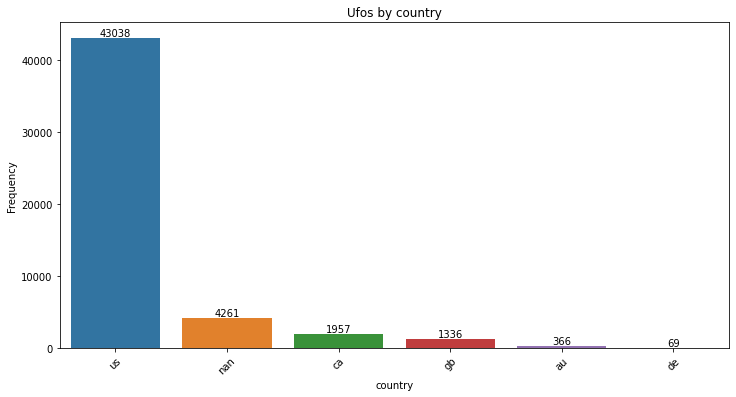

In [ ]:
get_country_bar_plot(ufo, 'country')

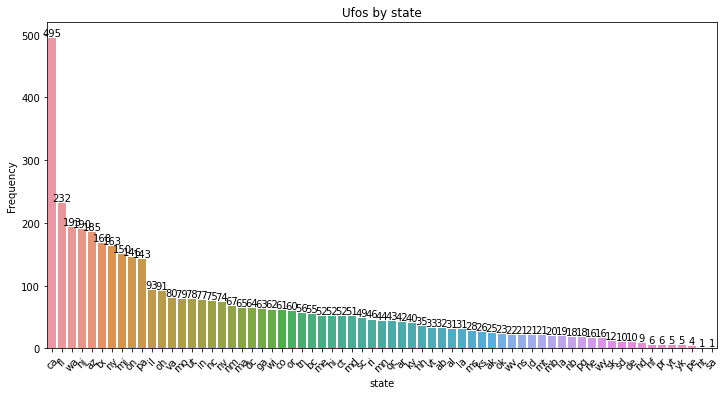

In [ ]:
subset = ufo[np.array(ufo['country'], str) == 'nan']
get_country_bar_plot(subset, 'state' )

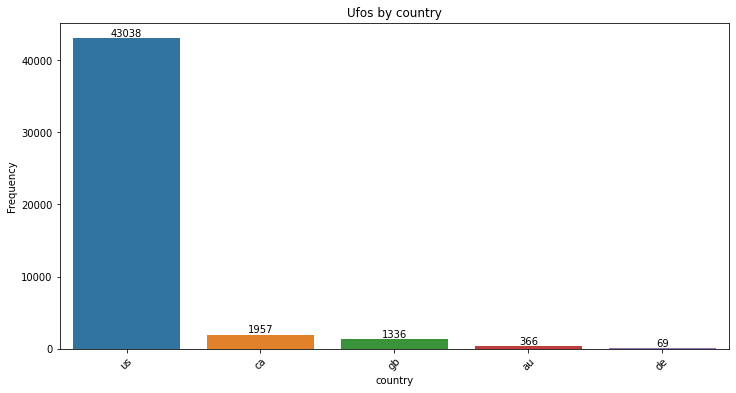

In [ ]:
ufo = ufo[np.array(ufo['country'], str)!='nan']
get_country_bar_plot(ufo, 'country')

In [ ]:
# UFO Date/Time Column Clean

print(ufo['datetime'][0])

date_cleaned = []

for date_time_str in ufo['datetime']:
  if date_time_str[-5:-3] == '24':
    date_time_str = date_time_str[:-5] + '23:59'
  date_time_obj = datetime.datetime.strptime(date_time_str, '%m/%d/%Y %H:%M')
  date_cleaned.append(date_time_obj)

ufo['datetime'] = date_cleaned
print(ufo['datetime'][0])

10/10/1949 20:30
1949-10-10 20:30:00


In [ ]:
length_of_set = len(ufo['datetime'])
print('Percentage of data remaining: {:.2f}%'.format(100*(length_of_set/80332)))

Percentage of data remaining: 58.22%


So far we have done a cleanup of the data, leaving the data that we believe is most likely to be from a real U.F.O. sighting. Remaining with $58.22\%$ of the original data


## Analysis of the United States data

As we can see in the frequency graphs by country. The United States is the most frequent country to report sightings

In [ ]:
ufo_us = ufo[ufo['country']=='us']

In [ ]:
# Most Frequent Months/Days/Hours on US
months = []
days = []
hour_of_day = []
month_days = []

# appending months/days/hours to their own list to analyse 
for date_object in ufo_us['datetime']: 
    months.append(int(date_object.month))
    days.append(int(date_object.day))
    hour_of_day.append(int(date_object.hour))

month_counter = Counter(months)
day_counter = Counter(days)
hour_counter = Counter(hour_of_day)

# Printing the top 5 most common date types
print("Months:")
print(month_counter.most_common(6))
print("Days:")
print(day_counter.most_common(10))
print("Hours:")
print(hour_counter.most_common(10))


Months:
[(7, 4897), (6, 4456), (8, 4409), (10, 4144), (9, 4032), (11, 3678)]
Days:
[(15, 3391), (1, 3174), (20, 1611), (4, 1610), (10, 1609), (30, 1418), (13, 1358), (12, 1353), (5, 1340), (14, 1333)]
Hours:
[(21, 5868), (22, 5436), (20, 4519), (23, 4221), (19, 3259), (18, 2201), (0, 2086), (1, 1658), (17, 1544), (2, 1205)]


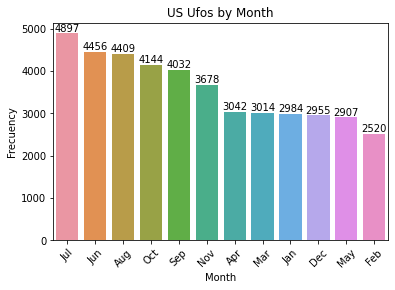

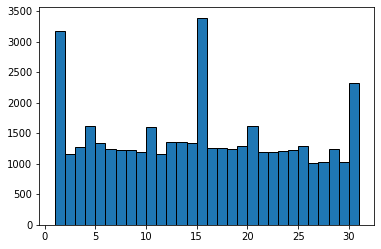

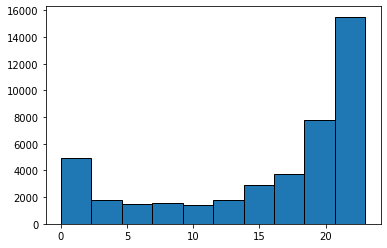

In [ ]:
# Months Histogram

def get_month_bar_plot(month_counter):
  dic = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 
         8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
  
  col1 = []
  col2 = []
  for month, count in month_counter.most_common(12):
    col1.append(dic[month])
    col2.append(count)

  d = {'Month': col1, 'Frecuency': col2}
  d = pd.DataFrame(d, columns=['Month', 'Frecuency'])
  plots = sns.barplot(x='Month', y='Frecuency', data = d)

  for bar in plots.patches:
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
  plt.xticks(rotation=45)
  plt.title('US Ufos by Month')
  plt.show()

get_month_bar_plot(month_counter)

# Days Histogram
plt.hist(days, bins=30, edgecolor='black')
plt.show()

#Hours Histogram
plt.hist(hour_of_day, edgecolor='black')
plt.show()



As can be seen, the months in which the most sightings have occurred are July and June respectively.

Days:
[(15, 1018), (1, 979), (4, 690), (30, 499), (20, 350)]
Hours:
[(22, 1712), (21, 1394), (23, 1175), (20, 678), (0, 484), (1, 421), (19, 396), (2, 316), (18, 284), (15, 245)]


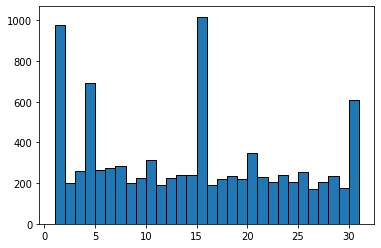

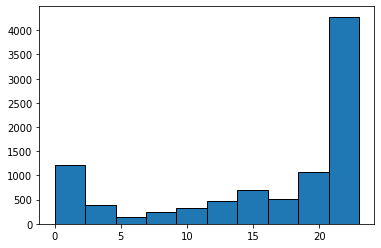

In [ ]:
days = []
hour_of_day = []


# appending months/days/hours to their own list to analyse 
for date_object in ufo_us['datetime']: 
  if int(date_object.month) == 6 or int(date_object.month) == 7:
    days.append(int(date_object.day))
    hour_of_day.append(int(date_object.hour))


day_counter = Counter(days)
hour_counter = Counter(hour_of_day)

# Printing the top 5 most common in june and july
print("Days:")
print(day_counter.most_common(5))
print("Hours:")
print(hour_counter.most_common(10))

# Days Histogram
plt.hist(days, bins=30, edgecolor='black')
plt.show()

#Hours Histogram
plt.hist(hour_of_day, edgecolor='black')
plt.show()

As we can see, a certain pattern is repeated in terms of the days of the month and the time in which the sightings have occurred.

So far we have that if you are in the United States, in the months of June and July on days 1, 4,15, 20 or 30. It is possible, although unlikely, that you precede a true UFO event. But to increase this probability, where should we be? The United States is a very large country.

In [ ]:
state_counter = Counter(ufo_us['state'])
print()
print("Most Common States")
print(state_counter.most_common(5))


Most Common States
[('ca', 5856), ('wa', 2537), ('fl', 2476), ('tx', 2345), ('ny', 2033)]


Well we have narrowed the space to 5 most likely states (California, Whashintong, Florida and New Yorck) but these are still very large states. Let's see if we can narrow down the possible locations a little more

In [ ]:
#City Column Clean
city_column = ufo_us['city']
expression = re.compile("\((.*?)\)")

# sort through JSON object with regular expressions
city_cleaned = []
for value in city_column:
    results = expression.findall(value)
    try:
      split_res = re.split(", ", results[0])
      city_cleaned.append(split_res[0])
    except:
      city_cleaned.append(value)

ufo_us_copy = ufo_us.copy()
ufo_us_copy['city'] = city_cleaned

city_counter = Counter(city_cleaned)
print(city_counter.most_common(5))

[('seattle', 352), ('phoenix', 306), ('las vegas', 257), ('los angeles', 243), ('portland', 239)]


In [ ]:
ufo_us = ufo_us_copy

Here are the 5 cities where the most sightings have been preceded. (Seattle, Phoenix, Las Vegas, Los Angeles, Portland)

If instead of being guided by the distribution of land that states or cities give us (generally very large) we use a grouping agorithm to group the location data (latitude and longitude), we can increase the number of groups until obtaining smaller regions where sightings are most likely to occur.

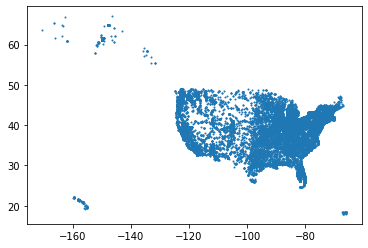

In [ ]:
# Position 

lon = np.array(ufo_us['longitude '],float)
lat = np.array(ufo_us['latitude'], float)
coord_pairs = np.vstack((lat, lon)).T

plt.scatter(coord_pairs[:,1], coord_pairs[:,0], s=1)
plt.show()

Although many people across the country saw UFO's there is a large scarcity of sightings in Alaska. This is most likely due to population density. More sightings in more populated areas could mean that a bunch of people witnessed the same event.

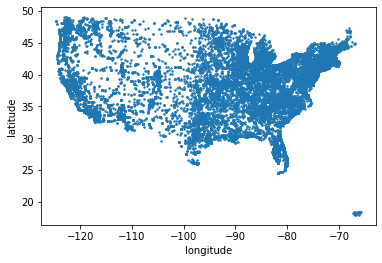

In [ ]:
# Filtering Out Outliers

# make new list without alaska and hawaii 
lower_48_pairs = []
for pair in coord_pairs: 
    if pair[1] > -125:
        lower_48_pairs.append(pair)
        
lat_array = []
long_array = []
for pair in lower_48_pairs:
    lat_array.append(pair[0])
    long_array.append(pair[1])

plt.scatter(long_array, lat_array, s=2)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [ ]:
url = 'https://drive.google.com/file/d/1nGDq9AcH980xFjDUph7TkPf8cWyQSA9W/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
cities = pd.read_csv(dwn_url, encoding='latin1')

from random import sample

cities_loc = np.vstack((np.array(cities['lat'], float), np.array(cities['lng'],float))).T

sam = sample( range(cities_loc.shape[0]) , 300)
cities_loc = cities_loc[sam,:]

lower_pairs_cities = []
for pair in cities_loc: 
    if pair[1] > -125 and pair[1]<-60:
        lower_pairs_cities.append(pair)

lower_pairs_cities = np.array(lower_pairs_cities)

[(17, 3495), (1, 3345), (10, 2647), (4, 2604), (8, 2320), (0, 2119), (3, 2091), (12, 2075), (18, 2006), (5, 1980)]


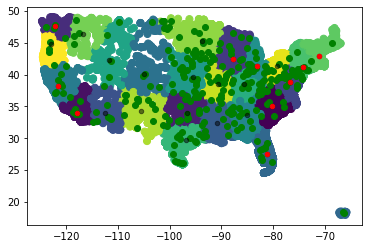

[(6, 2333), (36, 2129), (3, 2019), (35, 1783), (16, 1762), (9, 1616), (7, 1455), (19, 1443), (4, 1433), (17, 1408)]


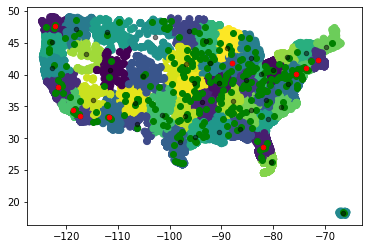

[(22, 1946), (3, 1857), (9, 1686), (11, 1615), (23, 1521), (7, 1224), (57, 1134), (67, 1127), (0, 1120), (58, 930)]


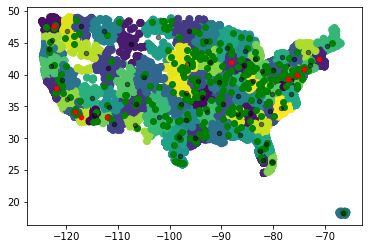

[(88, 1595), (19, 1521), (30, 1502), (11, 1300), (13, 1278), (39, 992), (46, 952), (3, 930), (10, 886), (69, 871)]


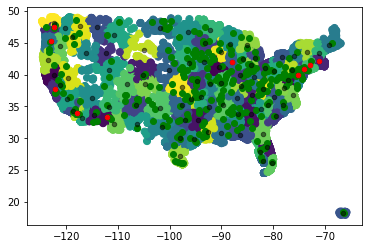

[(11, 1488), (98, 1040), (64, 1030), (16, 927), (167, 719), (37, 712), (38, 689), (22, 649), (58, 647), (196, 629)]


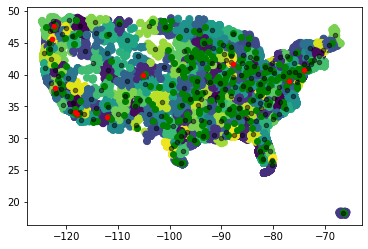

In [ ]:
# Clustering 
n_clusters = [25, 50, 75, 100, 200]

for cluster in n_clusters:
    kmeans = KMeans(n_clusters = cluster)
    kmeans.fit(lower_48_pairs)
    
#     predict the main regions of the UFO sightings 
    y_kmeans = kmeans.predict(lower_48_pairs)
    
        
    plt.scatter(long_array, lat_array, c=y_kmeans, s=50, cmap='viridis')
    plt.scatter(lower_pairs_cities[:,1], lower_pairs_cities[:,0], c='green')
# predict the cluster_centers 
    centers = np.array(kmeans.cluster_centers_)
    plt.scatter(centers[:, 1], centers[:, 0], c='black', s=20, alpha=0.5)
    counter = Counter(y_kmeans).most_common(10)
    print(counter)
    
    for count in counter:
      plt.scatter(centers[count[0],1], centers[count[0], 0], c='red', s=20)#, alpha=0.5)
    #    print(centers[count[0]])
    #    print(count[1])
    plt.show()

In [ ]:
print((len(ufo_us)/len(ufo['datetime']))*100)

92.02839669845613


The previous graphs show with red dots,the regions where is more likely to see an UFO. The green dots represent the most important cities of USA to be used as reference to find the red dots location.

# Conclusion and next steps

Of all UFO sighting data, $92.03\%$ were reported in the United States. For this reason, a more in-depth analysis of the sightings in that country was carried out. And we are going to take into account only these results

To be able to witness a sighting, without leaving it to chance, it is necessary to consider several factors such as:
* Month
* Day
* Hour
* location


Although the probability of seeing such an event is low. We can tempt our luck if we know well when and where to go.


$31.98 \%$ of sightings in the US were registered in June, July and August, with the highest number reported in July. Restricting only to these months, we also see that sightings are more likely to occur in the final days or beginning of the month. In addition, the graphs also show that these are more frequent in the hours of 18:00 pm to 02:00 am the next day

So if you are thinking of taking a vacation and seeing some aliens, then the indicated date is in the mentioned days of the months of July, June or August. But what about the location:

Well, despite knowing the most repeated states and cities in the reports, a map has been provided with the 10 locations with the highest density of reported cases.

What do we expect to see?

Given that those data that were most likely related to natural events were removed from these data, although we cannot guarantee that you will be able to experience a real sighting with high probability, you will be able to meet people or relatives who did.